<h1><b>ĐỒ ÁN CUỐI KỲ NMKHDL</b></h1>
<h2><b>POKEDEX</b></h2>

Họ tên: Nguyễn Đăng Quang

MSSV: 18120527



# Giới thiệu sơ lược
##### Có thể bạn chưa biết, Pocket Monsters viết tắt là Pokemon, một series game cũng như anime đình đám, series game Pokemon phát triển bởi GameFreak hiện vẫn đang làm mưa làm gió trên các hệ máy Nitendo và trên thị trường game toàn cầu. Nhân dịp gen9 (Scarlet & Violet) của game vừa ra mắt, chúng ta sẽ điểm lại các pokemon từ những thế hệ trước và thông số cũng như đặc tính của chúng thông qua Pokedex. Ở đây, chúng ta sẽ sử dụng "https://pokemondb.net/pokedex/all" là trang web chứa dữ liệu Pokedex, hay nói cách khác là danh sách của toàn bộ Pokemon ĐÃ xuất hiện xuyên suốt series game này. Let's go!

# Install và import
- bs4 (Beautiful Soup): Một thư viện Python dùng để phân tích các tài liệu HTML và XML. Nó tạo ra một cây phân tích cú pháp cho các trang được phân tích cú pháp có thể được sử dụng để trích xuất dữ liệu từ HTML, rất hữu ích cho web scrapping.
- requests: Cho phép gửi các yêu cầu HTTP bằng Python.

In [30]:
!pip install bs4
!pip install requests

In [31]:
!cd

c:\Users\Dell\Desktop\Data Science\DS\FINAL_PROJECT


In [32]:
import bs4
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Thu thập và xử lý dữ liệu
### 1. Lấy danh sách các id riêng biệt của từng Pokemon
- **Lưu ý:** 

      - Có thể các Pokemon có rất nhiều dạng (vùng miền, mega evolution, mega X/mega Y, nguyên thủy (primal form), tấn công/phòng thủ,...), hình dạng Pokemon thay đổi nhưng id thì vẫn giữ nguyên, vì vậy sẽ xuất hiện trường hợp một id lặp lại nhiều lần, chúng ta chỉ xét hình dạng cơ bản của chúng nên chỉ cần lấy 1 id cho mỗi Pokemon thôi. 

In [33]:
url = 'https://pokemondb.net/pokedex/all'

source = requests.get(url).text
soup = bs4.BeautifulSoup(source,'html.parser')

# Thu thập id của toàn bộ pokemon
pokemon_id = soup.findAll('span', {'class': 'infocard-cell-data'})

id = []

for i in range(len(pokemon_id)):
    id.append(pokemon_id[i].text)
    id[i] = int(id[i])

id = list(set(id))      # Sắp xếp và xóa các id bị trùng

### 2. Danh sách các url của từng Pokemon
- Chúng ta có thể dùng id hoặc tên của Pokemon để làm subdirectory của url tương ứng với Pokemon đó. 

##### Ví dụ: Pokemon có tên là Bulbasaur, id là 001:

https://pokemondb.net/pokedex/bulbasaur

https://pokemondb.net/pokedex/001 hay https://pokemondb.net/pokedex/1

In [34]:
# Lấy danh sách urls cho web scrapping
urls = []
n = len(id)

for i in range(n):
    urls.append('https://pokemondb.net/pokedex/' + str(id[i]))

### 3. Thu thập dữ liệu
#### 3.1. Thông tin
- Lưu ý: ID của Pokemon sẽ được thêm vào sau cùng sau đó đặt ID làm cột index, ở đây chúng ta chỉ xét các thuộc tính như: tên, hệ, loài,...
- Sẽ có thêm các cơ sở dữ liệu riêng để mô tả tác dụng của các đặc tính cũng như đặc tính ẩn và tương khắc hệ của chúng
- Các thông tin của một Pokemon sẽ bao gồm:

            - name: Tên

            - types_list: Hệ của Pokemon, mỗi con sẽ mang 1 hệ hoặc song hệ

            - species: Loài

            - height: Chiều cao

            - weight: Cân nặng

            - ability: Đặc tính

            - hid_ability (hidden ability): Đặc tính ẩn

            - catch_rate: Tỉ lệ bắt trúng bằng Poke Ball, bị ảnh hưởng bởi rất nhiều yếu tố:
                    * HP hiện tại
                    * Loại bóng (Poke Ball, Great Ball, Ultra Ball,...), Master Ball có tỷ lệ thu phục là 100% với tất cả Pokemon
                    * Trạng thái hiện tại (Choáng, phỏng, nhiễm độc, ngủ, tê liệt,...)
        
            - base_fs (base friendship): Chỉ số thân thiện cơ bản, một số Pokemon có chỉ số thân thiện là 0, bọn này có vẻ không ưa con người cho lắm

            - base_exp: Số lượng exp cần thiết để lên 1 level bất kỳ được tính theo hàm mũ. Mỗi loại có công thức khác nhau và khá phức tạp:
                    * Ví dụ 1 công thức đơn giản nhất cho mọi người:
                        Loại 1 000 000: exp = n^3 
                        n là level cần lên.
                        -> Để lên lv3 Pokemon loại này cần tổng cộng là 27exp trừ số exp hiện có sẽ ra số exp cần phải luyện thêm
            
            - growth_rate: Tốc độ tăng trưởng:
                    * Erratic: 600.000 exp ở level 100
                    * Fast: 800.000 điểm kinh nghiệm ở cấp 100
                    * Medium Fast: 1.000.000 điểm kinh nghiệm ở cấp 100
                    * Medium Slow: 1.059.860 điểm kinh nghiệm ở cấp 100
                    * Slow: 1.250.000 điểm kinh nghiệm ở cấp 100
                    * Fluctuating: 1.640.000 exp ở cấp 100:
        
            - genders: Giới tính theo tỷ lệ

            - Base Stats: Chỉ số cơ bản, bao gồm: 
                    * hp (Health Point): Sinh mệnh
                    * atk (Attack): Tấn công
                    * defn (Defense): Phòng thủ, giáp (Vì def là khai báo hàm nên không dùng để khai báo biến cho Defense được :v)
                    * sp_atk (Special Attack): Tấn công đặc biệt, sát thương phép
                    * sp_def (Special Defense): Phòng thủ đặc biệt, kháng phép
                    * spd (Speed): Tốc độ (tương tự như các game xoay tua, Pokemon tốc độ cao hơn sẽ được đánh trước)
                    
            - total: Tổng base stats


- Hàm get_pokemon_info(soup) giúp lấy ra thông tin của một Pokemon có ID chỉ định. Sau đó sẽ dùng vòng lặp để lấy thông tin toàn bộ Pokemon trong Pokedex

In [35]:
# Thu thập dữ liệu nào
def get_pokemon_info(soup):
    # name
    name = soup.find('h1').text

    # types
    types_list = soup.find_all('td')[1].text.replace('\n', '')      # 'type1 type2 '
    types_list = types_list[:-1].split(' ')                         # 'type1 type2'

    # type1, type2
    type1 = types_list[0]
    
    if (len(types_list) == 2):   # Pokemon mang song hệ
        type2 = types_list[1]
    else: 
        type2 = ''              # Pokemon mang 1 hệ

    # species
    species = soup.find_all('td')[2].text

    # height
    height = soup.find_all('td')[3].text.replace('\xa0', '')

    # weight
    weight = soup.find_all('td')[4].text.replace('\xa0', '')

    # ability
    ability = soup.find_all('span', {'class': 'text-muted'})[0].text.replace('1. ', '')

    # extra ability
    if '2. ' in soup.findAll(class_='text-muted')[1].text:
        ex_ability = soup.findAll(class_='text-muted')[1].text.replace('2. ', '')
    else: 
        ex_ability = ''
        
    
    # hidden ability
    hid_ability = soup.find_all('small', {'class': 'text-muted'})[0].text.replace(' (hidden ability)', '')
    if '(' in hid_ability:  # Pokemon không có hidden ability nên bị đọc nhầm sang khu vực xuất hiện
        hid_ability = ''

    # catch_rate
    catch_rate = soup.find_all('td')[8].text.replace('\n', '')

    # base friendship 
    base_fs = soup.find_all('td')[9].text.replace('\n', '')

    # base exp
    base_exp = soup.find_all('td')[10].text.replace('\n', '')

    # growth_rate
    growth_rate = soup.find_all('td')[11].text.replace('\n', '')

    # genders
    genders = soup.find_all('td')[13].text.replace('\n', '')

    # base stats (base, min, max): health point, attack, defense, special attack, special defense, speed, total (base)
    hp = int(soup.find_all('td')[15].text.replace('\n', ''))

    atk = int(soup.find_all('td')[19].text.replace('\n', ''))

    defn = int(soup.find_all('td')[23].text.replace('\n', ''))

    sp_atk = int(soup.find_all('td')[27].text.replace('\n', ''))
    
    sp_def = int(soup.find_all('td')[31].text.replace('\n', ''))

    spd =  int(soup.find_all('td')[35].text.replace('\n', ''))

    total = int(soup.find_all('td')[39].text)

    return name, type1, type2, species, height, weight, ability, ex_ability, hid_ability, catch_rate, base_fs, base_exp, growth_rate, genders, hp, atk, defn, sp_atk, sp_def, spd, total

#### 3.2. Tương khắc hệ
- Tương khắc hệ (Type Defenses) của một Pokemon là khả năng chịu đòn của một Pokemon trước những đòn tấn công mang hệ khác. Các Pokemon Trainer sẽ dựa vào tương khắc hệ này của chúng nhằm chọn ra Pokemon có ưu thế về hệ (Type Advantages) tốt nhất để đối đầu với Pokemon của đối thủ.

        Ví dụ: Bulbasaur mang song hệ là Grass/Poison:
                - Fire -> Grass/Poison = 2 <=> Đòn đánh hệ Fire sẽ gây gấp đôi sát thương lên Pokemon này
                - Grass -> Grass/Poison = 1/4   <=> Đòn đánh hệ Grass sẽ gây 1/4 sát thương lên Pokemon này

- Hàm type_defense(soup) sẽ trả về tương khắc hệ của Pokemon có url tương ứng. 

In [36]:
def type_defense(soup):
    type_defenses = []

    for i in range(40, 58):
        type_defenses.append(soup.findAll('td')[i].text)

    return type_defenses

#### 3.3. Đặc tính
- Đặc tính (Ability) và đặc tính ẩn (Hidden Ability): Là những đặc tính được trao cho mỗi Pokémon để có thể hỗ trợ chúng trong trận chiến, chúng ta sẽ lấy thông tin mô tả ngắn gọn toàn bộ đặc tính ở trang "https://pokemondb.net/ability".
- Một vài lợi ích đi kèm như: Thay đổi thời tiết, cường hóa tuyệt chiêu hoặc chỉ số, miễn nhiễm sát thương, giảm tấn công,...
 
        - Ví dụ: 
             * 'Intimidate' giảm chỉ số Attack của đối phương
             * 'Levitate' là trạng thái lơ lửng của Pokemon cho phép chúng miễn nhiễm với các đòn tấn công hệ Đất (Ground)
                
- Theo "https://pokemondb.net/ability", đặc tính và đặc tính ẩn đều gộp chung lại thành một danh sách được gọi là "The ability list".
- Danh sách này chứa:

                - Name: Tên đặc tính và đặc tính ẩn
                - Pokémon: Số lượng Pokemon sở hữu đặc tính đó
                - Description: Mô tả ngắn gọn về dặc tính đó
                - Gen: Thế hệ mà đặc tính đó được giới thiệu lần đầu

- Chúng ta chỉ cần quan tâm Name và Description.
- Hàm get_abilities_description(soup) trả về kết quả mô tả ngắn gọn về các Ability và Hidden Ability tương tứng.
- Lưu ý: 

        - Một vài Pokemon KHÔNG sở hữu Hidden Ability vì thế nội dung mô tả sẽ để trống
        - Hàm này chỉ trả về tên và mô tả các đặc tính ĐÃ ĐƯỢC GIỚI THIỆU XUYÊN SUỐT SERIES GAME POKEMON chứ không phải của từng Pokemon.

In [37]:
def get_abilities_description():
    source = requests.get('https://pokemondb.net/ability').text
    soup = bs4.BeautifulSoup(source,'html.parser')
    
    n1 = len(soup.findAll('tr')) - 1
    ability = []
    ability_des = []

    for i in range(n1):
        ability.append(soup.find_all('a', {'class': 'ent-name'})[i].text)
        ability_des.append(soup.find_all('td', {'class': 'cell-med-text'})[i].text)

    # blanked values
    ability.append('')
    ability_des.append('')
    return {k: v for k, v in zip(ability, ability_des)}

#### 3.4. Bắt đầu lấy thông tin, tương khắc hệ, đặc tính của từng Pokemon

In [38]:
data = []      # Thông tin
type_def = []  # Tương khắc hệ

for url in urls:
    source = requests.get(url).text
    soup = bs4.BeautifulSoup(source,'html.parser')
    # Lấy thông tin của từng Pokemon
    data.append(get_pokemon_info(soup))

    # Tương khắc hệ của từng Pokemon
    type_def.append(type_defense(soup))

# Mô tả đặc tính
abilities = get_abilities_description()

#### 3.4.1. Cơ sở dữ liệu thông tin Pokemon
- Sau khi đã có danh sách thông tin của toàn bộ Pokemon trong Pokedex, khởi tạo một cơ sở dữ liệu để lưu trữ
- Index ở đây sẽ là ID của từng Pokemon, bắt đầu từ 1.

In [39]:
pokedex = pd.DataFrame(data = data, columns=['Name', 'Type 1', 'Type 2', 'Species', 'Height', 'Weight', 'Ability', 'Extra Ability', 'Hidden Ability',
                                             'Catch Rate', 'Base Friendship', 'Base Exp', 'Growth Rate', 'Gender',
                                             'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Total'], index = id)
pokedex

,Name,Type 1,Type 2,Species,Height,Weight,Ability,Extra Ability,Hidden Ability,Catch Rate,...,Base Exp,Growth Rate,Gender,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Total
1,Bulbasaur,Grass,Poison,Seed Pokémon,0.7m (2′04″),6.9kg (15.2lbs),Overgrow,,Chlorophyll,"45 (5.9% with PokéBall, full HP)",...,64,Medium Slow,"87.5% male, 12.5% female",45,49,49,65,65,45,318
2,Ivysaur,Grass,Poison,Seed Pokémon,1.0m (3′03″),13.0kg (28.7lbs),Overgrow,,Chlorophyll,"45 (5.9% with PokéBall, full HP)",...,142,Medium Slow,"87.5% male, 12.5% female",60,62,63,80,80,60,405
3,Venusaur,Grass,Poison,Seed Pokémon,2.0m (6′07″),100.0kg (220.5lbs),Overgrow,,Chlorophyll,"45 (5.9% with PokéBall, full HP)",...,236,Medium Slow,"87.5% male, 12.5% female",80,82,83,100,100,80,525
4,Charmander,Fire,,Lizard Pokémon,0.6m (2′00″),8.5kg (18.7lbs),Blaze,,Solar Power,"45 (5.9% with PokéBall, full HP)",...,62,Medium Slow,"87.5% male, 12.5% female",39,52,43,60,50,65,309
5,Charmeleon,Fire,,Flame Pokémon,1.1m (3′07″),19.0kg (41.9lbs),Blaze,,Solar Power,"45 (5.9% with PokéBall, full HP)",...,142,Medium Slow,"87.5% male, 12.5% female",58,64,58,80,65,80,405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
901,Ursaluna,Ground,Normal,Peat Pokémon,2.4m (7′10″),290.0kg (639.3lbs),Guts,Bulletproof,Unnerve,"20 (2.6% with PokéBall, full HP)",...,—,Medium Fast,"50% male, 50% female",130,140,105,45,80,50,550
902,Basculegion,Water,Ghost,Big Fish Pokémon,3.0m (9′10″),110.0kg (242.5lbs),Swift Swim,Adaptability,Mold Breaker,"45 (5.9% with PokéBall, full HP)",...,—,Medium Fast,"100% male, 0% female",120,112,65,80,75,78,530
903,Sneasler,Poison,Fighting,Free Climb Pokémon,1.3m (4′03″),43.0kg (94.8lbs),Pressure,Unburden,Poison Touch,"20 (2.6% with PokéBall, full HP)",...,—,Medium Slow,"50% male, 50% female",80,130,60,40,80,120,510
904,Overqwil,Dark,Poison,Pin Cluster Pokémon,2.5m (8′02″),60.5kg (133.4lbs),Poison Point,Swift Swim,Intimidate,"45 (5.9% with PokéBall, full HP)",...,—,Medium Fast,"50% male, 50% female",85,115,95,65,65,85,510


#### 3.4.2. Cơ sở dữ liệu tương khắc hệ
- Tạo cơ sở dữ liệu để lưu trữ chỉ số tương khắc hệ.
- Chuẩn hóa dữ liệu dòng và thêm cột 'Name' chứa tên các Pokemon.

In [40]:
# Tạo csdl chứa tương khắc hệ
type_defenses = pd.DataFrame(data = type_def, columns = ['NORMAL', 'FIRE', 'WATER', 'ELECTRIC', 'GRASS', 'ICE', 
                                        'FIGHTING', 'POISON', 'GROUND', 'FLYING', 'SPYCHIC', 'BUG',
                                        'ROCK', 'GHOST', 'DRAGON', 'DARK', 'STEEL', 'FAIRY'], index = id)

# Thay đổi giá trị các dòng cho dễ nhìn
wrong = ['', '½', '¼', '1½', '⅛']
right = ['1', '0.5', '0.25', '1.5', 1/3]

for i, j in zip(wrong, right):
    type_defenses = type_defenses.replace(i ,j)

# Thêm tên vào cơ dở dữ liệu
type_defenses.insert(0, 'Name', pokedex['Name'])
type_defenses.insert(1, 'Type 1', pokedex['Type 1'])
type_defenses.insert(2, 'Type 2', pokedex['Type 2'])

type_defenses

,Name,Type 1,Type 2,NORMAL,FIRE,WATER,ELECTRIC,GRASS,ICE,FIGHTING,...,GROUND,FLYING,SPYCHIC,BUG,ROCK,GHOST,DRAGON,DARK,STEEL,FAIRY
1,Bulbasaur,Grass,Poison,1,2,0.5,0.5,0.25,2,0.5,...,1,2,2,1,1,1,1,1,1,0.5
2,Ivysaur,Grass,Poison,1,2,0.5,0.5,0.25,2,0.5,...,1,2,2,1,1,1,1,1,1,0.5
3,Venusaur,Grass,Poison,1,2,0.5,0.5,0.25,2,0.5,...,1,2,2,1,1,1,1,1,1,0.5
4,Charmander,Fire,,1,0.5,2,1,0.5,0.5,1,...,2,1,1,0.5,2,1,1,1,0.5,0.5
5,Charmeleon,Fire,,1,0.5,2,1,0.5,0.5,1,...,2,1,1,0.5,2,1,1,1,0.5,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
901,Ursaluna,Ground,Normal,1,1,2,0,2,2,2,...,1,1,1,1,0.5,0,1,1,1,1
902,Basculegion,Water,Ghost,0,0.5,0.5,2,2,0.5,0,...,1,1,1,0.5,1,2,1,2,0.5,1
903,Sneasler,Poison,Fighting,1,1,1,1,0.5,1,0.5,...,2,2,4,0.25,0.5,1,1,0.5,1,1
904,Overqwil,Dark,Poison,1,1,1,1,0.5,1,1,...,2,1,0,1,1,0.5,1,0.5,1,1


#### 3.4.3. Cơ sở dữ liệu mô tả các đặc tính
- Ý tưởng thực hiện:

                - B1: Trước tiên tạo database mới với tên, đặc tính, đặc tính ẩn Pokemon từ database cũ.
                - B2: Tạo 3 list là abi_des, ex_abi_des và hid_abi_des.
                - B3: Vì đặc tính 'Sharpness' vẫn chưa cập nhập mô tả trên "https://pokemondb.net/ability". Ta sẽ cập nhập thủ công cho đặc tính này.
                - B4: Chạy vòng lặp từ 1 đến n+1 ứng với id từ 1 -> 905  (n = 905)
                - B5: Tạo các biến tạm để lưu giữ các Ability theo id
                - B6: abilities[temp] trả về mô tả ngắn gọn Ability tương ứng của Pokemon đó, tương tự như temp2 và temp3 với EA và HA.
                - B7: Tạo thêm 3 cột để chứa dữ liệu của 3 list.
                - B8: In csdl ra màn hình để kiểm tra.

In [41]:
# Tạo csdl chứa tên và đặc tính tương ứng của từng Pokemon
abilities_info = pokedex[['Name', 'Ability', 'Extra Ability', 'Hidden Ability']]     # B1

# B2
abi_des = []        # ability description
ex_abi_des = []     # extra ability description
hid_abi_des = []    # hidden ability description

# B3
abilities['Sharpness'] = 'Powers up slicing moves'

# B4
for i in range(1, n+1):
    # B5
    temp = abilities_info['Ability'][i]
    temp2 = abilities_info['Extra Ability'][i]
    temp3 = abilities_info['Hidden Ability'][i]
    
    # B6
    abi_des.append(abilities[temp])
    ex_abi_des.append(abilities[temp2])
    hid_abi_des.append(abilities[temp3])


# B7
abilities_info.insert(2, 'Ability Description', abi_des)
abilities_info.insert(4, 'Extra Ability Description', ex_abi_des)
abilities_info.insert(6, 'Hidden Ability Description', hid_abi_des)

# B8
abilities_info

,Name,Ability,Ability Description,Extra Ability,Extra Ability Description,Hidden Ability,Hidden Ability Description
1,Bulbasaur,Overgrow,Powers up Grass-type moves in a pinch.,,,Chlorophyll,Boosts the Pokémon's Speed in sunshine.
2,Ivysaur,Overgrow,Powers up Grass-type moves in a pinch.,,,Chlorophyll,Boosts the Pokémon's Speed in sunshine.
3,Venusaur,Overgrow,Powers up Grass-type moves in a pinch.,,,Chlorophyll,Boosts the Pokémon's Speed in sunshine.
4,Charmander,Blaze,Powers up Fire-type moves in a pinch.,,,Solar Power,"In sunshine, Sp. Atk is boosted but HP decreases."
5,Charmeleon,Blaze,Powers up Fire-type moves in a pinch.,,,Solar Power,"In sunshine, Sp. Atk is boosted but HP decreases."
...,...,...,...,...,...,...,...
901,Ursaluna,Guts,Boosts Attack if there is a status problem.,Bulletproof,Protects the Pokémon from ball and bomb moves.,Unnerve,Makes the foe nervous and unable to eat Berries.
902,Basculegion,Swift Swim,Boosts the Pokémon's Speed in rain.,Adaptability,Powers up moves of the same type.,Mold Breaker,Moves can be used regardless of Abilities.
903,Sneasler,Pressure,The Pokémon raises the foe's PP usage.,Unburden,Raises Speed if a held item is used.,Poison Touch,May poison targets when a Pokémon makes contact.
904,Overqwil,Poison Point,Contact with the Pokémon may poison the attacker.,Swift Swim,Boosts the Pokémon's Speed in rain.,Intimidate,Lowers the foe's Attack stat.


# Xuất dữ liệu đã đọc được vào các file csv

In [42]:
pokedex.to_csv('pokemon_db.csv', encoding='utf-8', index = True)
type_defenses.to_csv('type_defenses.csv', encoding='utf-8', index = True)
abilities_info.to_csv('abilities_description.csv', encoding='utf-8', index = True)

# Q & A

### 1. Các Pokemon phân bố theo hệ như thế nào? 

- Tất cả các Pokemon đều có 1 hoặc 2 hệ. Với các Pokemon có 1 hệ:

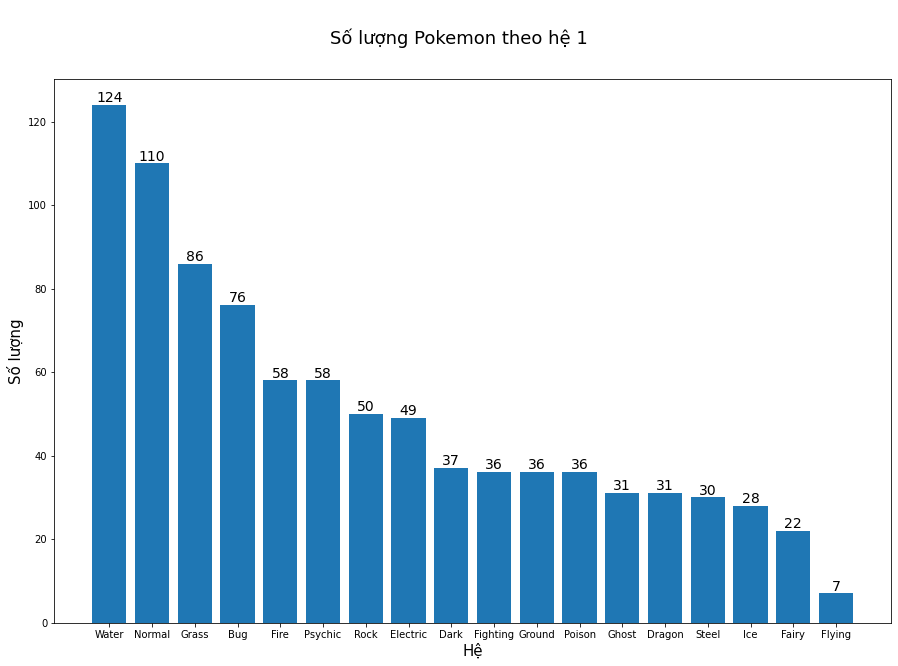

In [43]:
data = pokedex['Type 1'].value_counts()
fig,ax = plt.subplots(figsize = (15,10))
ax.bar(data.keys(), data.values)

# xlabel, ylabel, suptitle
ax.set_xlabel('Hệ', fontsize=15)
ax.set_ylabel('Số lượng', fontsize=15)
plt.suptitle('\nSố lượng Pokemon theo hệ 1', fontsize=18)

# bar labels
for bars in ax.containers:
    ax.bar_label(bars, fontsize=14)

plt.show()

- Với các Pokemon mang song hệ, hệ 2 của chúng phân bố như sau:

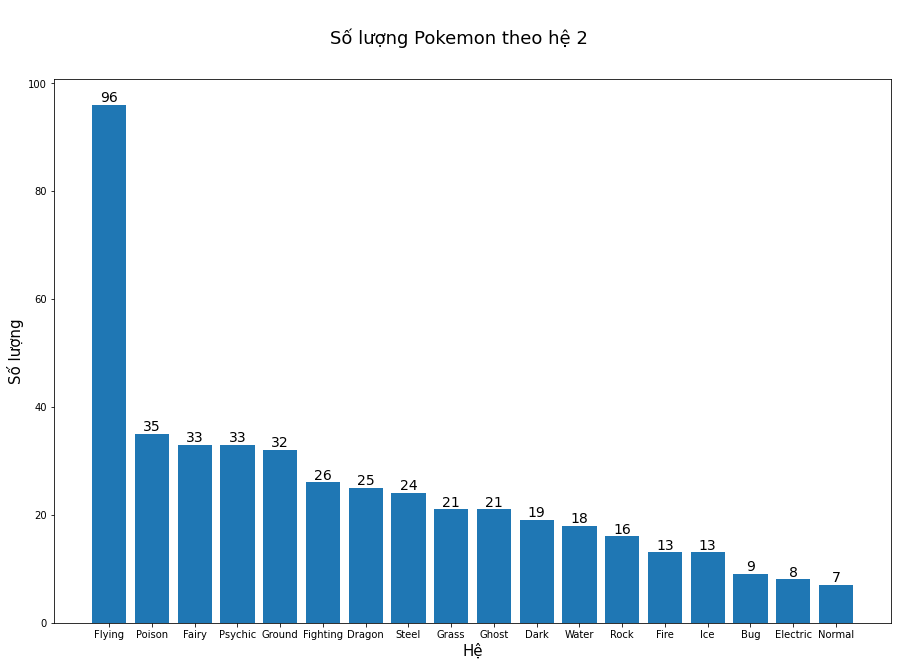

In [44]:
data1 = pokedex['Type 2'][pokedex['Type 2'] != ''].value_counts()

fig,ax = plt.subplots(figsize = (15,10))
ax.bar(data1.keys(), data1.values)

# xlabel, ylabel, suptitle
ax.set_xlabel('Hệ', fontsize=15)
ax.set_ylabel('Số lượng', fontsize=15)
plt.suptitle('\nSố lượng Pokemon theo hệ 2', fontsize=18)

# bar labels
for bars in ax.containers:
    ax.bar_label(bars, fontsize=14)

plt.show()

- Kết hợp cả 2 đồ thị lại, ta được:

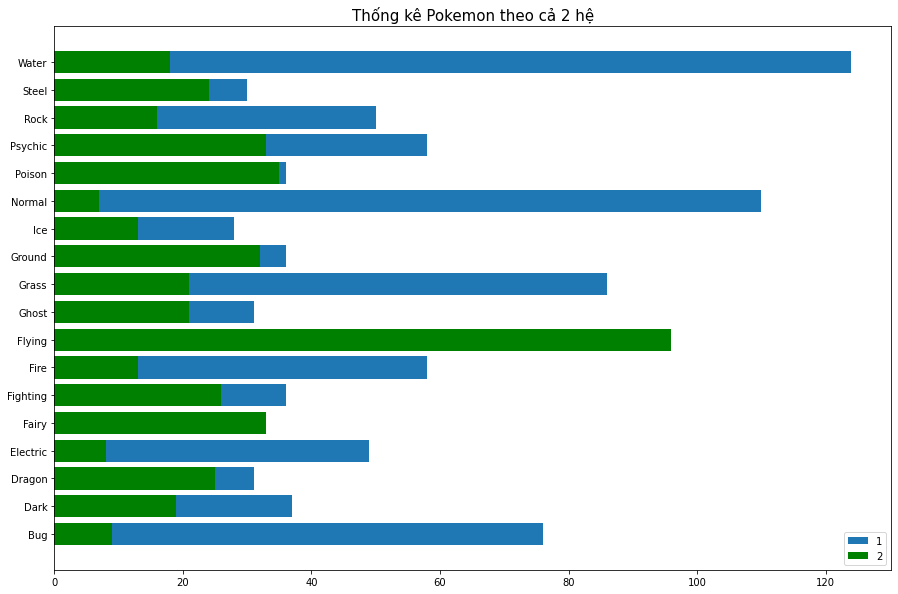

In [45]:
type1 = pokedex[['Type 1', 'Name']]\
                .rename(columns={'Type 1': 'Type', 'Name': 'Number'}) \
                .groupby('Type')\
                .count()

temp = pokedex[pokedex['Type 2'] != '']

type2 = temp[['Type 2', 'Name']]\
                .rename(columns={'Type 2': 'Type','Name': 'Number'}) \
                .groupby('Type')\
                .count()

xx = type1.index

fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.barh(xx, type1['Number'])
plt.barh(xx, type2['Number'],  color = 'green')
plt.title('Thống kê Pokemon theo cả 2 hệ', fontsize = 15)
plt.legend('12')
plt.show()

In [46]:
print('Số lượng Pokemon mang song hệ:', data1.sum(), '/' , data.sum())

Số lượng Pokemon mang song hệ: 449 / 905


- Nhận xét:
        
        - Số lượng Pokemon mang song hệ chiếm gần 50% tổng số Pokemon ĐÃ xuất hiện
        - Các hệ Water, Normal nhiều nhất ở hệ 1, nhưng lại ít xuất hiện hơn hẳn ở hệ 2.
        - Flying thường sẽ là hệ 2 của các Pokemon.
        - Một vài hệ có vẻ khá là hiếm ở Type 1, mặc dù đó là hệ phổ biến.

### 2. Pokemon mang hệ nào là tốt nhất? 

- Trừ các cột **Name, Type 1, Type 2** ra, chúng ta chỉ quan tâm chỉ số chống chịu của Pokemon với các hệ còn lại:

In [47]:
best_types_list = pd.DataFrame()

cols = type_defenses.columns[3:]

for col in cols:
    best_types_list[col] = type_defenses[col].astype(float)

best_types_list

,NORMAL,FIRE,WATER,ELECTRIC,GRASS,ICE,FIGHTING,POISON,GROUND,FLYING,SPYCHIC,BUG,ROCK,GHOST,DRAGON,DARK,STEEL,FAIRY
1,1.0,2.0,0.5,0.5,0.25,2.0,0.50,1.0,1.0,2.0,2.0,1.00,1.0,1.0,1.0,1.0,1.0,0.5
2,1.0,2.0,0.5,0.5,0.25,2.0,0.50,1.0,1.0,2.0,2.0,1.00,1.0,1.0,1.0,1.0,1.0,0.5
3,1.0,2.0,0.5,0.5,0.25,2.0,0.50,1.0,1.0,2.0,2.0,1.00,1.0,1.0,1.0,1.0,1.0,0.5
4,1.0,0.5,2.0,1.0,0.50,0.5,1.00,1.0,2.0,1.0,1.0,0.50,2.0,1.0,1.0,1.0,0.5,0.5
5,1.0,0.5,2.0,1.0,0.50,0.5,1.00,1.0,2.0,1.0,1.0,0.50,2.0,1.0,1.0,1.0,0.5,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
901,1.0,1.0,2.0,0.0,2.00,2.0,2.00,0.5,1.0,1.0,1.0,1.00,0.5,0.0,1.0,1.0,1.0,1.0
902,0.0,0.5,0.5,2.0,2.00,0.5,0.00,0.5,1.0,1.0,1.0,0.50,1.0,2.0,1.0,2.0,0.5,1.0
903,1.0,1.0,1.0,1.0,0.50,1.0,0.50,0.5,2.0,2.0,4.0,0.25,0.5,1.0,1.0,0.5,1.0,1.0
904,1.0,1.0,1.0,1.0,0.50,1.0,1.00,0.5,2.0,1.0,0.0,1.00,1.0,0.5,1.0,0.5,1.0,1.0


- Với `mean` càng cao thì sát thương gây ra cũng sẽ càng nhiều lên tất cả các hệ khác. Như vậy, top 5 hệ tốt nhất của chúng ta sẽ là:

ROCK      1.24
ICE       1.20
FLYING    1.19
FIRE      1.12
FAIRY     1.08
dtype: float64


<AxesSubplot:>

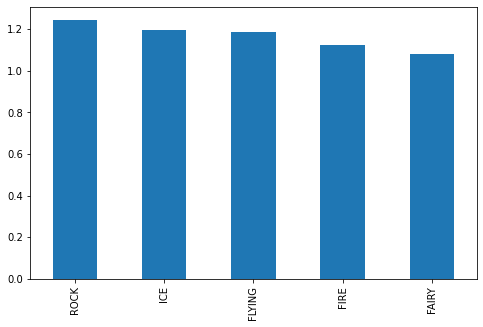

In [48]:
print(best_types_list.mean().sort_values(ascending=False)[0:5].round(2))
best_types_list.mean().sort_values(ascending=False)[0:5].plot(kind = 'bar', figsize = [8,5])

### 3. Cân nặng có liên quan gì đến khả năng chịu đòn của Pokemon hay không?

- Trước tiên Cân nặng của một Pokemon sẽ được tính theo `kg` và `lbs`, chúng ta sẽ quy về `kg` thông qua tiền xử lý:

In [49]:
pokemon_weight = []

for i in range(1, n + 1):
    pokemon_weight.append(pokedex['Weight'].str.split('kg')[i][0])

pokemon_weight = list(map(float, pokemon_weight))

pokemon_weight

[6.9,
 13.0,
 100.0,
 8.5,
 19.0,
 90.5,
 9.0,
 22.5,
 85.5,
 2.9,
 9.9,
 32.0,
 3.2,
 10.0,
 29.5,
 1.8,
 30.0,
 39.5,
 3.5,
 18.5,
 2.0,
 38.0,
 6.9,
 65.0,
 6.0,
 30.0,
 12.0,
 29.5,
 7.0,
 20.0,
 60.0,
 9.0,
 19.5,
 62.0,
 7.5,
 40.0,
 9.9,
 19.9,
 5.5,
 12.0,
 7.5,
 55.0,
 5.4,
 8.6,
 18.6,
 5.4,
 29.5,
 30.0,
 12.5,
 0.8,
 33.3,
 4.2,
 32.0,
 19.6,
 76.6,
 28.0,
 32.0,
 19.0,
 155.0,
 12.4,
 20.0,
 54.0,
 19.5,
 56.5,
 48.0,
 19.5,
 70.5,
 130.0,
 4.0,
 6.4,
 15.5,
 45.5,
 55.0,
 20.0,
 105.0,
 300.0,
 30.0,
 95.0,
 36.0,
 78.5,
 6.0,
 60.0,
 15.0,
 39.2,
 85.2,
 90.0,
 120.0,
 30.0,
 30.0,
 4.0,
 132.5,
 0.1,
 0.1,
 40.5,
 210.0,
 32.4,
 75.6,
 6.5,
 60.0,
 10.4,
 66.6,
 2.5,
 120.0,
 6.5,
 45.0,
 49.8,
 50.2,
 65.5,
 1.0,
 9.5,
 115.0,
 120.0,
 34.6,
 35.0,
 80.0,
 8.0,
 25.0,
 15.0,
 39.0,
 34.5,
 80.0,
 54.5,
 56.0,
 40.6,
 30.0,
 44.5,
 55.0,
 88.4,
 10.0,
 235.0,
 220.0,
 4.0,
 6.5,
 29.0,
 24.5,
 25.0,
 36.5,
 7.5,
 35.0,
 11.5,
 40.5,
 59.0,
 460.0,
 55.4,
 52.6,
 60.0,
 

- Khả năng chịu đòn của một Pokemon được quyết định dựa trên 3 thuộc tính chủ yếu:

        + Điểm sinh mệnh (HP)
        + Phòng thủ hoặc giáp (Defense)
        + Phòng thủ đặc biệt hay kháng phép (Special Defense):

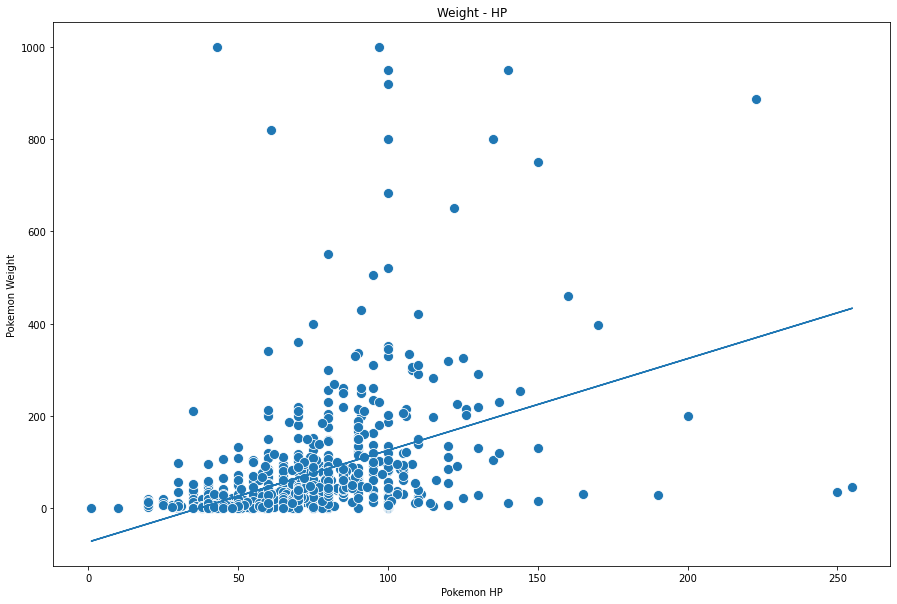

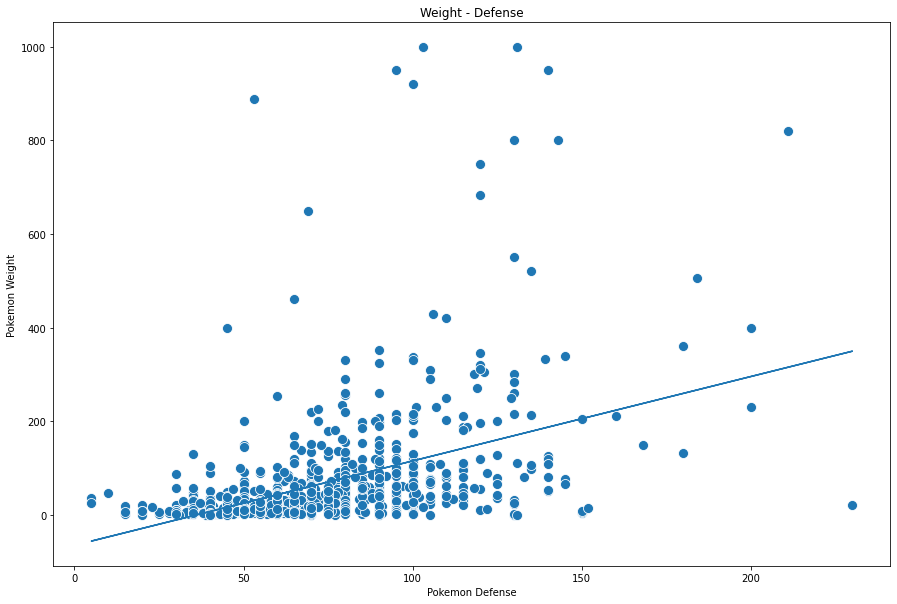

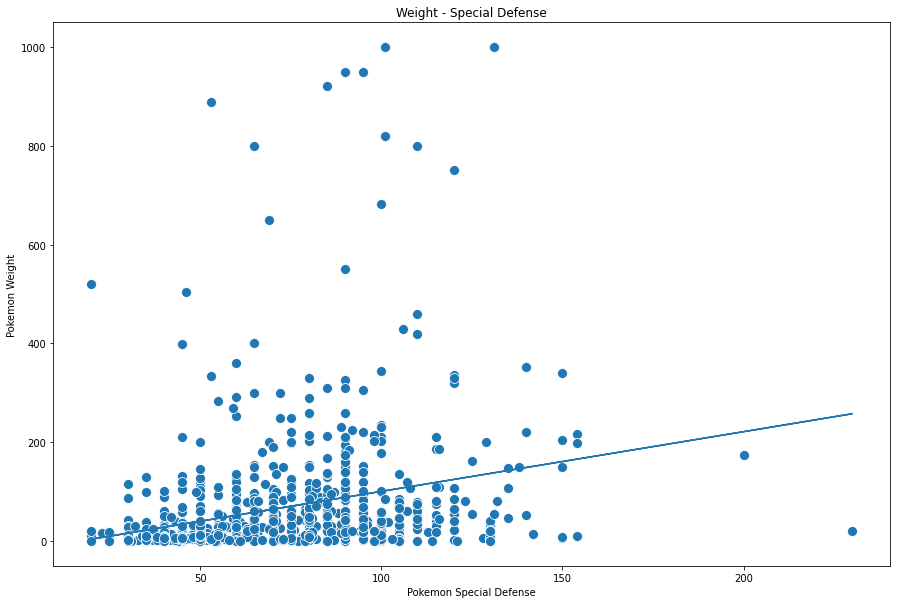

In [50]:
# HP
plt.figure(figsize = (15,10))

sns.scatterplot(data = pokedex,
                x = pokedex['HP'], 
                y = pokemon_weight, 
                marker = 'o',
                s = 100). \
                set(xlabel = 'Pokemon HP', ylabel = 'Pokemon Weight', title = 'Weight - HP')

m, b = np.polyfit(pokedex['HP'], pokemon_weight, 1)
plt.plot(pokedex['HP'], m*pokedex['HP']+b)


# DEFENSE
plt.figure(figsize = (15,10))

sns.scatterplot(data = pokedex,
                x = pokedex['Defense'], 
                y = pokemon_weight, 
                marker = 'o',
                s = 100). \
                set(xlabel = 'Pokemon Defense', ylabel = 'Pokemon Weight', title = 'Weight - Defense')

m, b = np.polyfit(pokedex['Defense'], pokemon_weight, 1)
plt.plot(pokedex['Defense'], m*pokedex['Defense']+b)


# SPECIAL DEFENSE
plt.figure(figsize = (15,10))

sns.scatterplot(data = pokedex,
                x = pokedex['Sp. Def'], 
                y = pokemon_weight, 
                marker = 'o',
                s = 100). \
                set(xlabel = 'Pokemon Special Defense', ylabel = 'Pokemon Weight', title = 'Weight - Special Defense')

m, b = np.polyfit(pokedex['Sp. Def'], pokemon_weight, 1)
plt.plot(pokedex['Sp. Def'], m*pokedex['Sp. Def']+b)

- Nhận xét: 

        + Xu hướng tăng dần chỉ số phòng ngự theo cân nặng của Pokemon là có cơ sở
        + Các Pokemon "nặng ký" thì sẽ có khả năng chịu đòn càng tốt
        + Như vậy để có một Pokemon chịu đòn tốt, hãy chọn mấy con Pokemon mập :v

### 4. Nếu dựa trên tương khắc hệ có thể suy ra được hệ tốt nhất cho một Pokemon. Vậy dựa trên chỉ số sức mạnh thì các hệ nào sẽ đứng top? 

           Total
Type 1          
Dragon    491.19
Steel     469.43
Psychic   449.43
Fire      443.67
Rock      439.34
Dark      438.32
Electric  434.59
Ghost     433.65
Fairy     432.45
Ice       432.25
Ground    427.58
Fighting  427.14
Flying    420.00
Water     418.05
Poison    415.17
Grass     407.92
Normal    397.78
Bug       375.14


<AxesSubplot:xlabel='Type 1'>

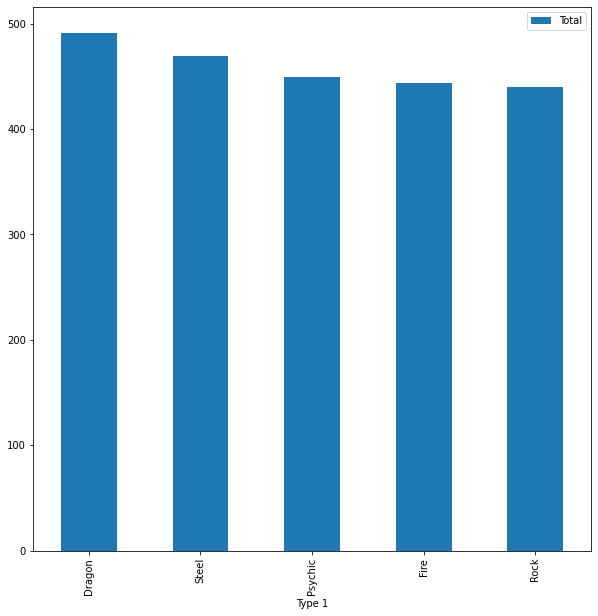

In [51]:
strongest_types_list = pokedex[['Name', 'Type 1', 'Total']]. \
                        groupby('Type 1'). \
                        mean('Total'). \
                        sort_values('Total', ascending = False)

print(round(strongest_types_list, 2))

strongest_types_list[0:5].plot(kind = 'bar', figsize = [10,10])

- Nhận xét:

        + DRAGON là hệ mạnh nhất, không có gì để bàn cãi cả.
        + FIRE và ROCK vừa là nằm trong top cả hệ tốt nhất và hệ mạnh nhất.

- Lưu ý:` Tuy DRAGON là hệ mạnh nhất nhưng vẫn không nằm trong các hệ tốt nhất là vì bọn này có chỉ số rất khủng, tuy vậy hệ tốt nhất chúng ta xét là dựa trên tương khắc hệ chứ không phải tổng chỉ số.`

### 5. Pokemon Á Thần, Huyền Bí và Huyền Thoại gồm những Pokemon nào?

- Trước hết, các Pokemon **Huyền Thoại (legendary)** ĐÃ được giới thiệu bao gồm những cái tên sau đây:

In [52]:
legendaries = ['Articuno', 'Zapdos', 'Moltres', 'Mewtwo', 'Raikou', 'Entei', 'Suicune', 'Lugia', 'Ho-oh', 'Regice', 
'Registeel', 'Regirock', 'Latias', 'Latios', 'Groudon', 'Kyogre', 'Rayquaza', 'Azelf', 'Mesprit', 'Uxie', 
'Dialga', 'Palkia', 'Giratina', 'Cresselia', 'Heatran', 'Regigigas', 'Cobalion', 'Terrakion', 'Virizion', 
'Tornadus', 'Thundurus', 'Landorus', 'Reshiram', 'Zekrom', 'Kyurem', 'Xerneas', 'Yveltal', 'Zygarde', 'Type: Null', 
'Silvally', 'Tapu Koko', 'Tapu Lele', 'Tapu Bulu', 'Tapu Fini', 'Cosmog', 'Cosmoem', 'Solgaleo', 'Lunala', 'Necrozma', 
'Zacian', 'Zamazenta', 'Eternatus', 'Kubfu', 'Urshifu', 'Regieleki', 'Regidrago', 'Glastrier', 'Spectrier', 'Calyrex']

pokedex['Legendary'] = pokedex['Name'].isin(legendaries)

pokedex[pokedex['Legendary'] == True]

,Name,Type 1,Type 2,Species,Height,Weight,Ability,Extra Ability,Hidden Ability,Catch Rate,...,Growth Rate,Gender,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Total,Legendary
144,Articuno,Ice,Flying,Freeze Pokémon,1.7m (5′07″),55.4kg (122.1lbs),Pressure,,Snow Cloak,"3 (0.4% with PokéBall, full HP)",...,Slow,Genderless,90,85,100,95,125,85,580,True
145,Zapdos,Electric,Flying,Electric Pokémon,1.6m (5′03″),52.6kg (116.0lbs),Pressure,,Static,"3 (0.4% with PokéBall, full HP)",...,Slow,Genderless,90,90,85,125,90,100,580,True
146,Moltres,Fire,Flying,Flame Pokémon,2.0m (6′07″),60.0kg (132.3lbs),Pressure,,Flame Body,"3 (0.4% with PokéBall, full HP)",...,Slow,Genderless,90,100,90,125,85,90,580,True
150,Mewtwo,Psychic,,Genetic Pokémon,2.0m (6′07″),122.0kg (269.0lbs),Pressure,,Unnerve,"3 (0.4% with PokéBall, full HP)",...,Slow,Genderless,106,110,90,154,90,130,680,True
243,Raikou,Electric,,Thunder Pokémon,1.9m (6′03″),178.0kg (392.4lbs),Pressure,,Inner Focus,"3 (0.4% with PokéBall, full HP)",...,Slow,Genderless,90,85,75,115,100,115,580,True
244,Entei,Fire,,Volcano Pokémon,2.1m (6′11″),198.0kg (436.5lbs),Pressure,,Inner Focus,"3 (0.4% with PokéBall, full HP)",...,Slow,Genderless,115,115,85,90,75,100,580,True
245,Suicune,Water,,Aurora Pokémon,2.0m (6′07″),187.0kg (412.3lbs),Pressure,,Inner Focus,"3 (0.4% with PokéBall, full HP)",...,Slow,Genderless,100,75,115,90,115,85,580,True
249,Lugia,Psychic,Flying,Diving Pokémon,5.2m (17′01″),216.0kg (476.2lbs),Pressure,,Multiscale,"3 (0.4% with PokéBall, full HP)",...,Slow,Genderless,106,90,130,90,154,110,680,True
250,Ho-oh,Fire,Flying,Rainbow Pokémon,3.8m (12′06″),199.0kg (438.7lbs),Pressure,,Regenerator,"3 (0.4% with PokéBall, full HP)",...,Slow,Genderless,106,130,90,110,154,90,680,True
377,Regirock,Rock,,Rock Peak Pokémon,1.7m (5′07″),230.0kg (507.1lbs),Clear Body,,Sturdy,"3 (0.4% with PokéBall, full HP)",...,Slow,Genderless,80,100,200,50,100,50,580,True


- Các Pokemon **Huyền Bí (mythical)** ĐÃ được giới thiệu bao gồm những cái tên sau đây:

In [53]:
mythicals = ['Mew', 'Celebi', 'Jirachi', 'Deoxys', 'Phione', 'Manaphy', 'Darkrai', 'Shaymin', 
'Arceus', 'Victini', 'Keldeo', 'Meloetta', 'Genesect', 'Diancie', 'Hoopa', 'Volcanion', 'Magearna',
'Marshadow', 'Zeraora', 'Meltan', 'Melmetal', 'Zarude']

pokedex['Mythical'] = pokedex['Name'].isin(mythicals)

pokedex[pokedex['Mythical'] == True]

,Name,Type 1,Type 2,Species,Height,Weight,Ability,Extra Ability,Hidden Ability,Catch Rate,...,Gender,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Total,Legendary,Mythical
151,Mew,Psychic,,New Species Pokémon,0.4m (1′04″),4.0kg (8.8lbs),Synchronize,,,"45 (5.9% with PokéBall, full HP)",...,Genderless,100,100,100,100,100,100,600,False,True
251,Celebi,Psychic,Grass,Time Travel Pokémon,0.6m (2′00″),5.0kg (11.0lbs),Natural Cure,,,"45 (5.9% with PokéBall, full HP)",...,Genderless,100,100,100,100,100,100,600,False,True
385,Jirachi,Steel,Psychic,Wish Pokémon,0.3m (1′00″),1.1kg (2.4lbs),Serene Grace,,,"3 (0.4% with PokéBall, full HP)",...,Genderless,100,100,100,100,100,100,600,False,True
386,Deoxys,Psychic,,DNA Pokémon,1.7m (5′07″),60.8kg (134.0lbs),Pressure,,,"3 (0.4% with PokéBall, full HP)",...,Genderless,50,150,50,150,50,150,600,False,True
489,Phione,Water,,Sea Drifter Pokémon,0.4m (1′04″),3.1kg (6.8lbs),Hydration,,,"30 (3.9% with PokéBall, full HP)",...,Genderless,80,80,80,80,80,80,480,False,True
490,Manaphy,Water,,Seafaring Pokémon,0.3m (1′00″),1.4kg (3.1lbs),Hydration,,,"3 (0.4% with PokéBall, full HP)",...,Genderless,100,100,100,100,100,100,600,False,True
491,Darkrai,Dark,,Pitch-Black Pokémon,1.5m (4′11″),50.5kg (111.3lbs),Bad Dreams,,,"3 (0.4% with PokéBall, full HP)",...,Genderless,70,90,90,135,90,125,600,False,True
492,Shaymin,Grass,,Gratitude Pokémon,0.2m (0′08″),2.1kg (4.6lbs),Natural Cure,,,"45 (5.9% with PokéBall, full HP)",...,Genderless,100,100,100,100,100,100,600,False,True
493,Arceus,Normal,,Alpha Pokémon,3.2m (10′06″),320.0kg (705.5lbs),Multitype,,,"3 (0.4% with PokéBall, full HP)",...,Genderless,120,120,120,120,120,120,720,False,True
494,Victini,Psychic,Fire,Victory Pokémon,0.4m (1′04″),4.0kg (8.8lbs),Victory Star,,,"3 (0.4% with PokéBall, full HP)",...,Genderless,100,100,100,100,100,100,600,False,True


- Các Pokemon **Á Thần (pseudo-legendary)** được giới thiệu trong tiếng Anh là `The 600 club (câu lạc bộ 600)` ám chỉ các Pokemon KHÔNG phải là Pokemon Huyền Thoại, cũng chả phải Huyền Bí và có tổng chỉ số trên 600, trừ con `Slaking`:

In [54]:
pokedex[pokedex['Legendary'] == False][pokedex['Mythical'] == False][pokedex['Total'] >= 600][pokedex['Name'] != 'Slaking']

C:\Users\Dell\AppData\Local\Temp/ipykernel_1360/2218166425.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pokedex[pokedex['Legendary'] == False][pokedex['Mythical'] == False][pokedex['Total'] >= 600][pokedex['Name'] != 'Slaking']


,Name,Type 1,Type 2,Species,Height,Weight,Ability,Extra Ability,Hidden Ability,Catch Rate,...,Gender,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Total,Legendary,Mythical
149,Dragonite,Dragon,Flying,Dragon Pokémon,2.2m (7′03″),210.0kg (463.0lbs),Inner Focus,,Multiscale,"45 (5.9% with PokéBall, full HP)",...,"50% male, 50% female",91,134,95,100,100,80,600,False,False
248,Tyranitar,Rock,Dark,Armor Pokémon,2.0m (6′07″),202.0kg (445.3lbs),Sand Stream,,Unnerve,"45 (5.9% with PokéBall, full HP)",...,"50% male, 50% female",100,134,110,95,100,61,600,False,False
373,Salamence,Dragon,Flying,Dragon Pokémon,1.5m (4′11″),102.6kg (226.2lbs),Intimidate,,Moxie,"45 (5.9% with PokéBall, full HP)",...,"50% male, 50% female",95,135,80,110,80,100,600,False,False
376,Metagross,Steel,Psychic,Iron Leg Pokémon,1.6m (5′03″),550.0kg (1212.5lbs),Clear Body,,Light Metal,"3 (0.4% with PokéBall, full HP)",...,Genderless,80,135,130,95,90,70,600,False,False
445,Garchomp,Dragon,Ground,Mach Pokémon,1.9m (6′03″),95.0kg (209.4lbs),Sand Veil,,Rough Skin,"45 (5.9% with PokéBall, full HP)",...,"50% male, 50% female",108,130,95,80,85,102,600,False,False
635,Hydreigon,Dark,Dragon,Brutal Pokémon,1.8m (5′11″),160.0kg (352.7lbs),Levitate,,,"45 (5.9% with PokéBall, full HP)",...,"50% male, 50% female",92,105,90,125,90,98,600,False,False
706,Goodra,Dragon,,Dragon Pokémon,2.0m (6′07″),150.5kg (331.8lbs),Sap Sipper,Hydration,Gooey,"45 (5.9% with PokéBall, full HP)",...,"50% male, 50% female",90,100,70,110,150,80,600,False,False
784,Kommo-o,Dragon,Fighting,Scaly Pokémon,1.6m (5′03″),78.2kg (172.4lbs),Bulletproof,Soundproof,Overcoat,"45 (5.9% with PokéBall, full HP)",...,"50% male, 50% female",75,110,125,100,105,85,600,False,False
887,Dragapult,Dragon,Ghost,Stealth Pokémon,3.0m (9′10″),50.0kg (110.2lbs),Clear Body,Infiltrator,Cursed Body,"45 (5.9% with PokéBall, full HP)",...,"50% male, 50% female",88,120,75,100,75,142,600,False,False


In [56]:
# Kiểm tra số lượng Pokemon huyền thoại, huyền bí trong Pokedex hiện tại có khớp với chiều dài danh sách không
print(pokedex[pokedex['Legendary'] == True].shape[0] == len(legendaries))
print(pokedex[pokedex['Mythical'] == True].shape[0] == len(mythicals))

True
True
